In [20]:
from pydub import AudioSegment # pip3 install pydub
import numpy as np
# import scipy.signal
from scipy.fft import rfft, irfft, rfftfreq, next_fast_len
import matplotlib.pyplot as plt
from scipy import signal

In [21]:
track_path = 'cloud-meditation-4868.mp3'

In [22]:
# we make 40Hz BB
boost = 1.7 

freqBB = 40.0
freqL = 420.0
freqR = 460.0

assert abs(freqL-freqR) == freqBB

working_bandwidth = 150.0
working_freq = (freqL+freqR)/2.0
min_working_freq, max_working_freq = working_freq - working_bandwidth/2, working_freq + working_bandwidth/2

In [23]:
# open track
track = AudioSegment.from_mp3(track_path)
frame_rate = track.frame_rate

# get samples from pydub to np.array
mono_samples = np.array([ch.get_array_of_samples() for ch in track.split_to_mono()], dtype=np.float32).mean(0)

# tukey window for 15s fade-in and 15s fade-out
window = signal.windows.tukey(mono_samples.shape[0], alpha=(15*2*frame_rate)/(mono_samples.shape[0]))
mono_samples = mono_samples*window

n_samples =mono_samples.shape[0]
fft_samples = next_fast_len(n_samples)


In [24]:
# get fft spectrum (positive only for real signals) and split it to working and rest
yf = rfft(mono_samples, n=fft_samples)
xf = rfftfreq(fft_samples, 1 / frame_rate)


In [25]:
# indexes of frequences to shift
working_mask = np.logical_and(xf>=min_working_freq, xf<=max_working_freq)
zeroring_mask = np.logical_and(xf>=min_working_freq-int(freqBB/2), xf<=max_working_freq+int(freqBB/2))

# 40Hz /2 to spectral samples 
samples_to_shift = int(freqBB/(xf[1]-xf[0])/2)

# process spectrums 
working_part = yf[working_mask]
yf_left, yf_right = yf.copy(), yf.copy()

yf_left[zeroring_mask] = 0.0
yf_right[zeroring_mask] = 0.0

yf_left[np.where(working_mask)[0] - samples_to_shift] = working_part*boost 
yf_right[np.where(working_mask)[0] + samples_to_shift] = working_part*boost


In [26]:
# reconstruct edited signals from spectrums
sigL = irfft(yf_left)[:n_samples]
sigR = irfft(yf_right)[:n_samples]

In [27]:
# normalize
max_sample_val = 2**15 - 1

sigR = (sigR * max_sample_val/sigR.max()).astype(np.int16)
sigL = (sigL * max_sample_val/sigL.max()).astype(np.int16)

In [28]:
channelL = AudioSegment(sigL.tobytes(), frame_rate=frame_rate, sample_width=sigL.dtype.itemsize, channels=1)
channelR = AudioSegment(sigR.tobytes(), frame_rate=frame_rate, sample_width=sigR.dtype.itemsize, channels=1)
stereo_sound = AudioSegment.from_mono_audiosegments(channelL, channelR)

In [29]:
stereo_sound.export(f"{track_path.replace('.mp3', '_40Hz.mp3')}", format="mp3")

<_io.BufferedRandom name='cloud-meditation-4868_40Hz.mp3'>

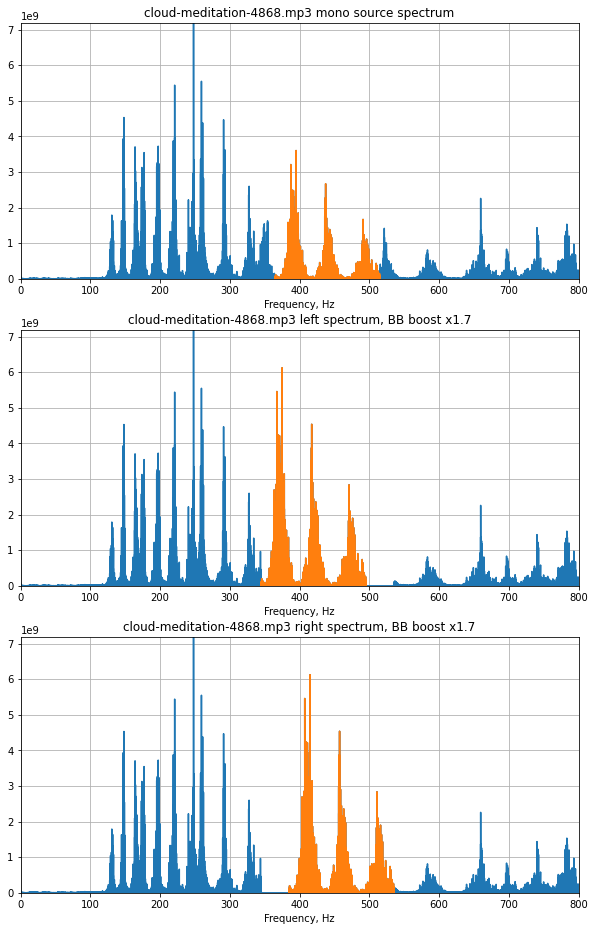

In [30]:
# plot figures
f800 = np.argmax(xf>800.0)
decimate_rate = 1

maskL = np.where(working_mask)[0] - samples_to_shift
maskR = np.where(working_mask)[0] + samples_to_shift

freqs = xf[:f800:decimate_rate]
mono_spec = abs(yf[:f800:decimate_rate])
left_spec = abs(yf_left[:f800:decimate_rate])
right_spec = abs(yf_right[:f800:decimate_rate])

ymax = max([mono_spec.max(), left_spec.max(), right_spec.max()])

plt.figure(figsize=(10,16)) 

plt.subplot(3,1,1)
plt.plot(freqs, mono_spec)
plt.plot(xf[working_mask], abs(yf[working_mask]))
plt.xlabel('Frequency, Hz')
plt.title(f'{track_path} mono source spectrum')
plt.xlim(0, 800)
plt.ylim(0, ymax)
plt.grid()

plt.subplot(3,1,2)
plt.plot(freqs, left_spec)
plt.plot(xf[maskL], abs(yf_left[maskL]))
plt.xlabel('Frequency, Hz')
plt.title(f'{track_path} left spectrum, BB boost x{boost}')
plt.xlim(0, 800)
plt.ylim(0, ymax)
plt.grid()

plt.subplot(3,1,3)
plt.plot(freqs, right_spec)
plt.plot(xf[maskR], abs(yf_right[maskR]))
plt.xlabel('Frequency, Hz')
plt.title(f'{track_path} right spectrum, BB boost x{boost}')
plt.xlim(0, 800)
plt.ylim(0, ymax)
plt.grid()

with open('spectrum.png', 'wb') as fb:
    plt.savefig(fb, format="png")